In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


from keras.utils import array_to_img, img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall

from sklearn.model_selection import train_test_split, KFold

2025-12-02 15:46:45.356480: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-02 15:46:45.706848: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-02 15:46:45.803960: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-12-02 15:46:45.803993: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not ha

# 1.Load Dataset

In [3]:
training_data_dir = "/home/aurore/code/afallo/brain_tumor_detection_project/raw_data/classification/Training/"
testing_data_dir = "/home/aurore/code/afallo/brain_tumor_detection_project/raw_data/classification/Testing/"

In [4]:
img = load_img(f"{training_data_dir}notumor/BRISC_brisc2025_train_02477_no_ax_t1.jpg")
x = img_to_array(img)/255  # We divide the pixel value by 255 to end up between 0 and 1

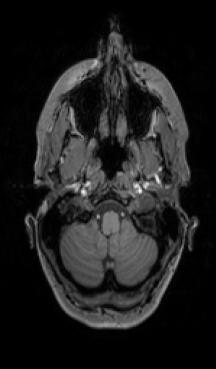

In [5]:
img

In [6]:
x.shape

(369, 216, 3)

## 1.1 Dataframe creation with images paths and label



In [7]:
def path_df(tr_path):
    classes = []
    class_paths = []

    for label in os.listdir(tr_path):
        folder = os.path.join(tr_path, label)
        if os.path.isdir(folder):
            for image in os.listdir(folder):
                classes.append(label)
                class_paths.append(os.path.join(folder, image))

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df


In [8]:
training_df = path_df(training_data_dir)

In [9]:
training_df


,Class Path,Class
0,/home/aurore/code/afallo/brain_tumor_detection...,glioma
1,/home/aurore/code/afallo/brain_tumor_detection...,glioma
2,/home/aurore/code/afallo/brain_tumor_detection...,glioma
3,/home/aurore/code/afallo/brain_tumor_detection...,glioma
4,/home/aurore/code/afallo/brain_tumor_detection...,glioma
...,...,...
11405,/home/aurore/code/afallo/brain_tumor_detection...,notumor
11406,/home/aurore/code/afallo/brain_tumor_detection...,notumor
11407,/home/aurore/code/afallo/brain_tumor_detection...,notumor
11408,/home/aurore/code/afallo/brain_tumor_detection...,notumor


In [10]:
testing_df = path_df(testing_data_dir)

In [15]:
def label(x):
    if x=="glioma"or x=="meningioma" or x=="pituitary" :
        x = "tumor"
    return x

In [16]:
training_df["Class"] = training_df["Class"].apply(label)
training_df

,Class Path,Class
0,/home/aurore/code/afallo/brain_tumor_detection...,tumor
1,/home/aurore/code/afallo/brain_tumor_detection...,tumor
2,/home/aurore/code/afallo/brain_tumor_detection...,tumor
3,/home/aurore/code/afallo/brain_tumor_detection...,tumor
4,/home/aurore/code/afallo/brain_tumor_detection...,tumor
...,...,...
11405,/home/aurore/code/afallo/brain_tumor_detection...,notumor
11406,/home/aurore/code/afallo/brain_tumor_detection...,notumor
11407,/home/aurore/code/afallo/brain_tumor_detection...,notumor
11408,/home/aurore/code/afallo/brain_tumor_detection...,notumor


In [17]:
testing_df["Class"] = testing_df["Class"].apply(label)
testing_df

,Class Path,Class
0,/home/aurore/code/afallo/brain_tumor_detection...,tumor
1,/home/aurore/code/afallo/brain_tumor_detection...,tumor
2,/home/aurore/code/afallo/brain_tumor_detection...,tumor
3,/home/aurore/code/afallo/brain_tumor_detection...,tumor
4,/home/aurore/code/afallo/brain_tumor_detection...,tumor
...,...,...
2492,/home/aurore/code/afallo/brain_tumor_detection...,notumor
2493,/home/aurore/code/afallo/brain_tumor_detection...,notumor
2494,/home/aurore/code/afallo/brain_tumor_detection...,notumor
2495,/home/aurore/code/afallo/brain_tumor_detection...,notumor


# 2.Train val test split

In [18]:
val_df, train_df = train_test_split(training_df, train_size=0.3, stratify=training_df['Class'])

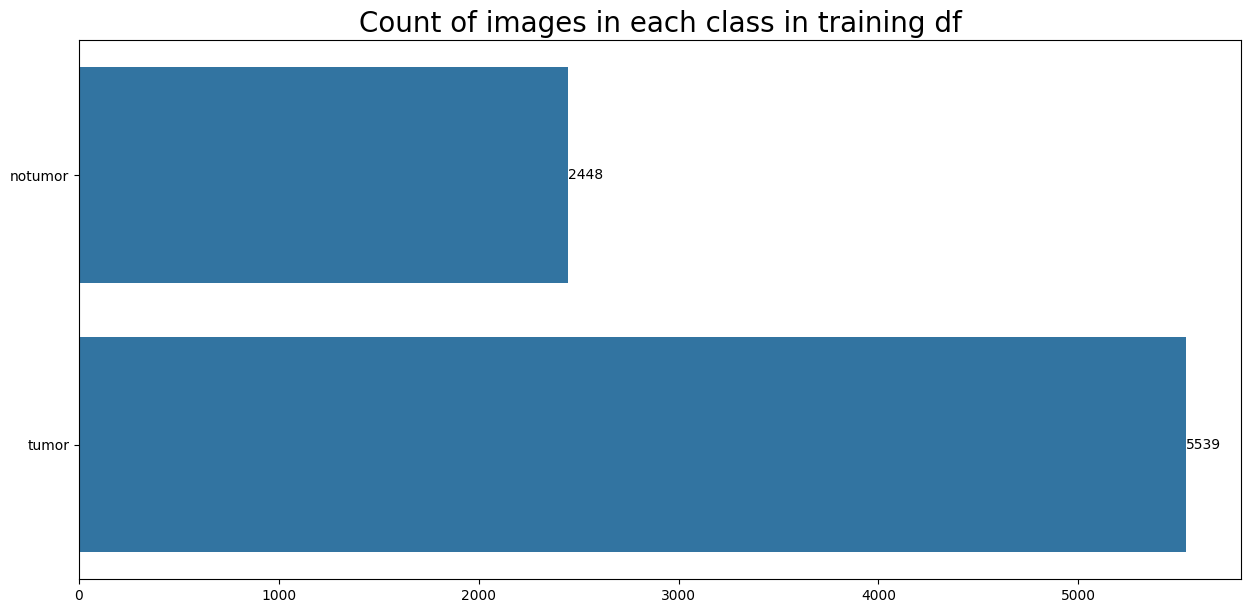

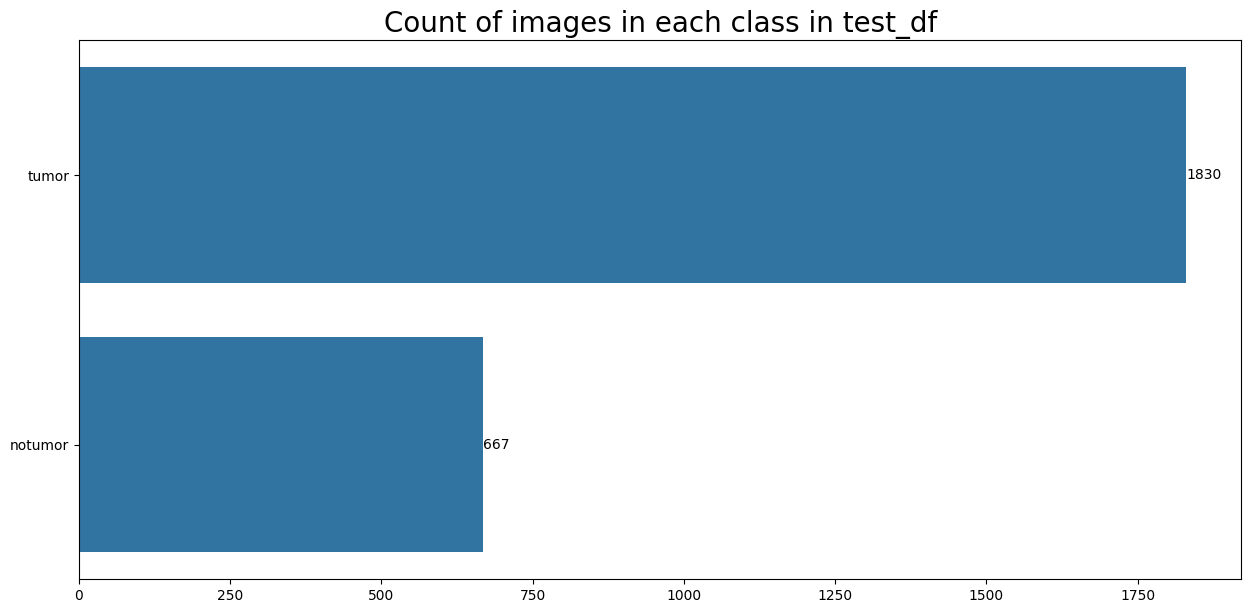

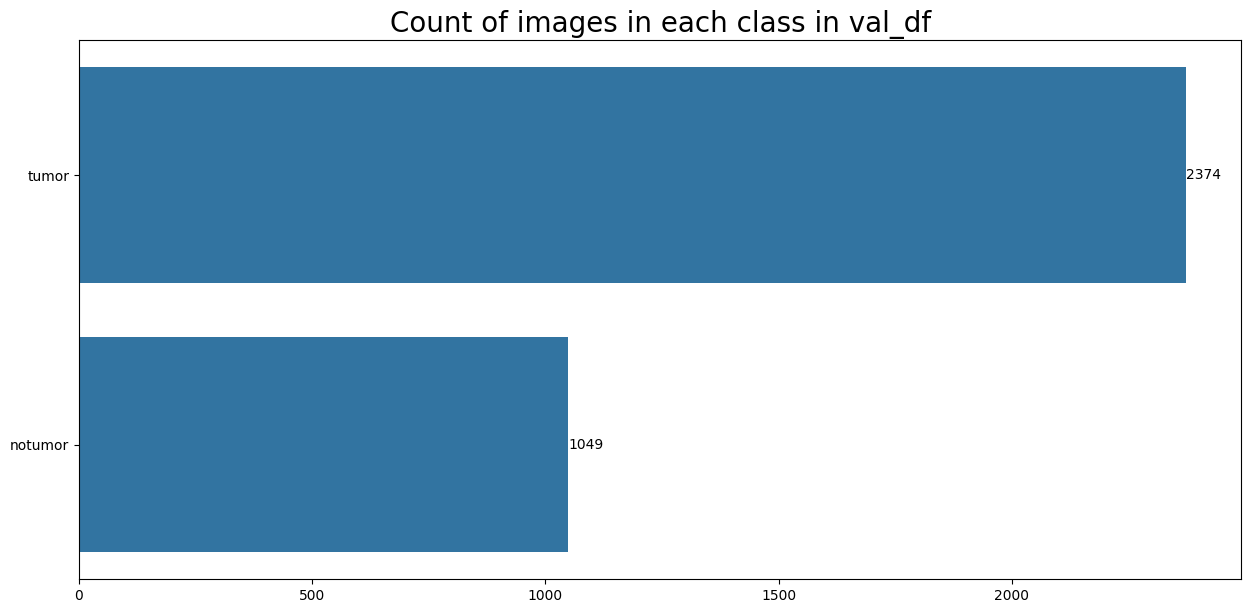

In [19]:
# Count of images in each class in train data
plt.figure(figsize=(15,7))
ax = sns.countplot(data=train_df , y=train_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class in training df', fontsize=20)
ax.bar_label(ax.containers[0])

plt.figure(figsize=(15,7))
ax = sns.countplot(data=testing_df , y=testing_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class in test_df', fontsize=20)
ax.bar_label(ax.containers[0])

plt.figure(figsize=(15,7))
ax = sns.countplot(data=val_df , y=val_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class in val_df', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

# 3.Preprocess

In [20]:
batch_size = 32
img_size = (225, 225)

scale = ImageDataGenerator(rescale=1/255)
scale_gen = ImageDataGenerator(rescale=1/255, brightness_range=(0.8,1.2))

train_scale_gen = scale_gen.flow_from_dataframe(train_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size, class_mode="binary")

train_scale = scale.flow_from_dataframe(train_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size, class_mode="binary")

val_scale_gen = scale_gen.flow_from_dataframe(val_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size, class_mode="binary")


val_scale = scale.flow_from_dataframe(val_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size, class_mode="binary")

test_scale = scale.flow_from_dataframe(testing_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size, class_mode="binary", shuffle = False)

Found 7987 validated image filenames belonging to 2 classes.
Found 7987 validated image filenames belonging to 2 classes.
Found 3423 validated image filenames belonging to 2 classes.
Found 3423 validated image filenames belonging to 2 classes.
Found 2495 validated image filenames belonging to 2 classes.


/home/aurore/.pyenv/versions/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 2 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
len(train_df)

7997

# 4.Base Model

In [21]:
def initialize_model():

    model = Sequential()
    model.add(Input(shape=(225, 225, 3)))

    ### First Convolution & MaxPooling
    model.add(layers.Conv2D(8, (4, 4), padding ='same', activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    ### Second Convolution & MaxPooling
    #model.add(layers.Conv2D(16, (3, 3), activation="relu"))
    #model.add(layers.MaxPool2D(pool_size=(2, 2)))

    ### Flattening
    model.add(layers.Flatten())

    ### One Fully Connected layer - "Fully Connected" is equivalent to saying "Dense"
    model.add(layers.Dense(5, activation='relu'))

    ### Last layer - Classification Layer with 10 outputs corresponding to 10 digits
    model.add(layers.Dense(1, activation='sigmoid'))

    ### Model compilation
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', Recall(), Precision()])
    return model

In [22]:
model = initialize_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 225, 225, 8)       392       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 8)      0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 5)                 501765    
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 502,163
Trainable params: 502,163
Non-trainable params: 0
__________________________________________________

2025-12-02 16:07:12.509229: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-12-02 16:07:12.509771: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2025-12-02 16:07:12.509846: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (MSI): /proc/driver/nvidia/version does not exist
2025-12-02 16:07:12.511944: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
es = EarlyStopping(patience = 5, restore_best_weights=True )
history = model.fit(train_scale,
                 epochs=20,
                 validation_data=val_scale,
                 callbacks = [es])

Epoch 1/20
250/250 [==============================] - 19s 73ms/step - loss: 0.6927 - accuracy: 0.6839 - recall: 0.9767 - precision: 0.6931 - val_loss: 0.6597 - val_accuracy: 0.6935 - val_recall: 1.0000 - val_precision: 0.6935
Epoch 2/20
250/250 [==============================] - 11s 43ms/step - loss: 0.6483 - accuracy: 0.6935 - recall: 1.0000 - precision: 0.6935 - val_loss: 0.6384 - val_accuracy: 0.6935 - val_recall: 1.0000 - val_precision: 0.6935
Epoch 3/20
250/250 [==============================] - 12s 48ms/step - loss: 0.6321 - accuracy: 0.6935 - recall: 1.0000 - precision: 0.6935 - val_loss: 0.6269 - val_accuracy: 0.6935 - val_recall: 1.0000 - val_precision: 0.6935
Epoch 4/20
250/250 [==============================] - 11s 42ms/step - loss: 0.6235 - accuracy: 0.6935 - recall: 1.0000 - precision: 0.6935 - val_loss: 0.6208 - val_accuracy: 0.6935 - val_recall: 1.0000 - val_precision: 0.6935
Epoch 5/20
250/250 [==============================] - 11s 44ms/step - loss: 0.6193 - accuracy: 0

In [26]:
def plot_history(history):

    fig, ax = plt.subplots(4, 1, figsize=(8,13))

    ax[0].set_title('loss')

    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")

    ax[1].set_title('Accuracy')

    ax[1].plot(history.epoch, history.history["accuracy"], label="Train Accuracy")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Accuracy")


    ax[2].set_title('Recall')

    ax[2].plot(history.epoch, history.history["recall"], label="Train recall")
    ax[2].plot(history.epoch, history.history["val_recall"], label="Validation recall")

    ax[3].set_title('Precision')

    ax[3].plot(history.epoch, history.history["precision"], label="precision")
    ax[3].plot(history.epoch, history.history["val_precision"], label="Validation precision")


    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    ax[3].legend()

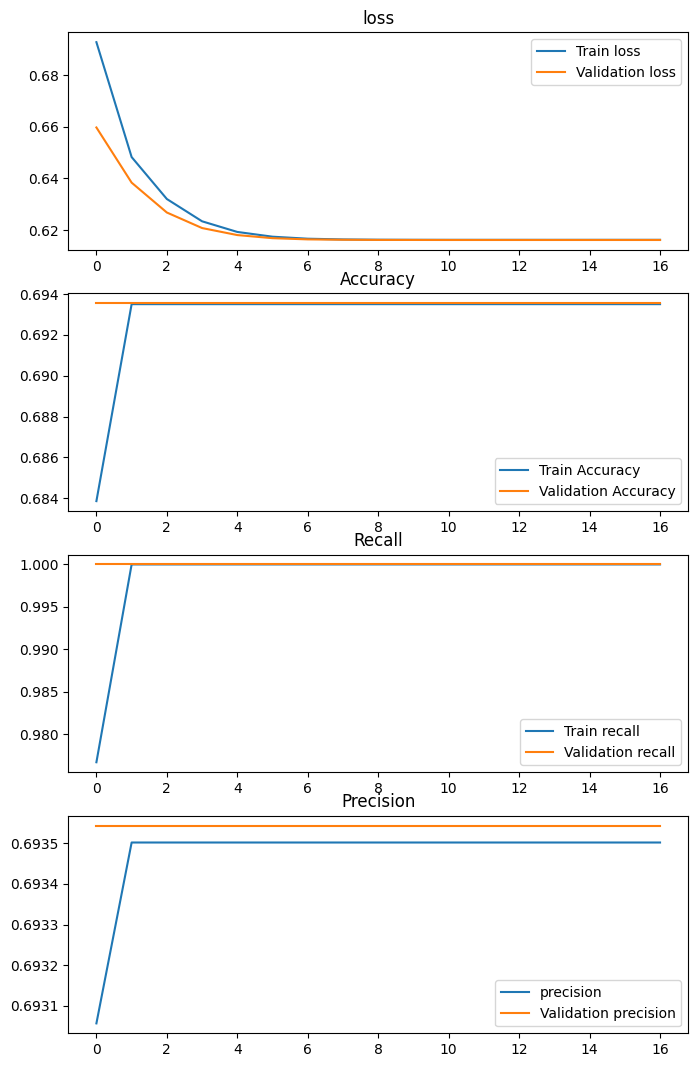

In [27]:

plot_history(history)


In [28]:
model.evaluate(test_scale)

78/78 [==============================] - 3s 44ms/step - loss: 0.5837 - accuracy: 0.7335 - recall: 1.0000 - precision: 0.7335


[0.5836607217788696, 0.7334669232368469, 1.0, 0.7334669232368469]

In [29]:
predictions = model.predict(test_scale, steps=len(test_scale))

78/78 [==============================] - 2s 27ms/step


In [30]:
y_pred = (predictions > 0.5).astype(int).ravel()


In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_scale.classes, y_pred)


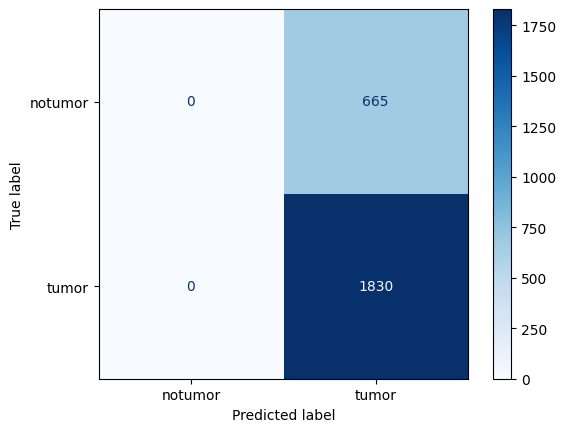

In [32]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_scale.class_indices.keys())
disp.plot(cmap='Blues')


In [33]:
predictions

array([[0.6933767],
       [0.6933767],
       [0.6933767],
       ...,
       [0.6933767],
       [0.6933767],
       [0.6933767]], dtype=float32)

In [18]:
test_df, train_val_df = train_test_split(df, train_size=0.2, stratify=df['Class'])

In [ ]:
""" %%time

kf = KFold(n_splits=5)
kf.get_n_splits(train_df)

results = []
es = EarlyStopping(patience = 5, restore_best_weights=True )

for train_index, test_index in kf.split(train_df):
#     # Split the data into train and test

    train_df, val_df = train_val_df.iloc[train_index], train_val_df.iloc[test_index]

#     # Scaling your data


    train_scale_gen = scale_gen.flow_from_dataframe(train_df, x_col='Class Path',
                                    y_col='Class', batch_size=batch_size,
                                    target_size=img_size, class_mode="binary")

    train_scale = scale.flow_from_dataframe(train_df, x_col='Class Path',
                                    y_col='Class', batch_size=batch_size,
                                    target_size=img_size, class_mode="binary")

    val_scale_gen = scale_gen.flow_from_dataframe(val_df, x_col='Class Path',
                                        y_col='Class', batch_size=batch_size,
                                        target_size=img_size, class_mode="binary")


    val_scale = scale.flow_from_dataframe(val_df, x_col='Class Path',
                                        y_col='Class', batch_size=batch_size,
                                        target_size=img_size, class_mode="binary")


    # 3. Model
    model = initialize_model()
    history = model.fit(train_scale,
                 epochs=20,
                 validation_data=val_scale,
                 callbacks = [es])

    # 4. Evaluation

    results.append(model.evaluate(val_scale)) """

Found 3249 validated image filenames belonging to 2 classes.


Found 3249 validated image filenames belonging to 2 classes.
Found 802 validated image filenames belonging to 2 classes.
Found 802 validated image filenames belonging to 2 classes.


/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 3423 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(
/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 3423 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(
/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 866 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(
/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 866 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/20
102/102 [==============================] - 9s 73ms/step - loss: 0.5630 - accuracy: 0.7929 - recall_2: 0.8398 - precision_2: 0.7898 - val_loss: 0.4841 - val_accuracy: 0.8716 - val_recall_2: 0.8500 - val_precision_2: 0.9100
Epoch 2/20
102/102 [==============================] - 7s 69ms/step - loss: 0.4644 - accuracy: 0.8852 - recall_2: 0.8860 - precision_2: 0.8998 - val_loss: 0.4348 - val_accuracy: 0.9127 - val_recall_2: 0.8955 - val_precision_2: 0.9426
Epoch 3/20
102/102 [==============================] - 7s 70ms/step - loss: 0.3921 - accuracy: 0.9388 - recall_2: 0.9299 - precision_2: 0.9555 - val_loss: 0.4101 - val_accuracy: 0.9015 - val_recall_2: 0.8545 - val_precision_2: 0.9616
Epoch 4/20
102/102 [==============================] - 7s 71ms/step - loss: 0.3458 - accuracy: 0.9575 - recall_2: 0.9515 - precision_2: 0.9692 - val_loss: 0.3741 - val_accuracy: 0.9252 - val_recall_2: 0.8864 - val_precision_2: 0.9750
Epoch 5/20
102/102 [==============================] - 7s 69ms/step -

/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 3406 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(
/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 3406 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(
/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 883 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(
/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 883 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/20
103/103 [==============================] - 8s 78ms/step - loss: 0.3768 - accuracy: 0.8463 - recall_3: 0.8319 - precision_3: 0.8767 - val_loss: 0.2285 - val_accuracy: 0.9261 - val_recall_3: 0.9400 - val_precision_3: 0.9271
Epoch 2/20
103/103 [==============================] - 9s 85ms/step - loss: 0.1542 - accuracy: 0.9513 - recall_3: 0.9466 - precision_3: 0.9625 - val_loss: 0.3020 - val_accuracy: 0.8866 - val_recall_3: 0.9769 - val_precision_3: 0.8426
Epoch 3/20
103/103 [==============================] - 9s 88ms/step - loss: 0.1013 - accuracy: 0.9694 - recall_3: 0.9676 - precision_3: 0.9754 - val_loss: 0.1704 - val_accuracy: 0.9401 - val_recall_3: 0.9515 - val_precision_3: 0.9406
Epoch 4/20
103/103 [==============================] - 9s 88ms/step - loss: 0.0595 - accuracy: 0.9825 - recall_3: 0.9801 - precision_3: 0.9874 - val_loss: 0.1547 - val_accuracy: 0.9516 - val_recall_3: 0.9561 - val_precision_3: 0.9561
Epoch 5/20
103/103 [==============================] - 10s 93ms/step 

/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 3412 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(
/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 3412 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(
/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 877 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(
/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 877 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(


102/102 [==============================] - 7s 69ms/step - loss: 0.7035 - accuracy: 0.5365 - recall_4: 0.9573 - precision_4: 0.5393 - val_loss: 0.6917 - val_accuracy: 0.5537 - val_recall_4: 1.0000 - val_precision_4: 0.5537
Epoch 2/20
102/102 [==============================] - 7s 73ms/step - loss: 0.6917 - accuracy: 0.5387 - recall_4: 1.0000 - precision_4: 0.5387 - val_loss: 0.6905 - val_accuracy: 0.5537 - val_recall_4: 1.0000 - val_precision_4: 0.5537
Epoch 3/20
102/102 [==============================] - 7s 67ms/step - loss: 0.6911 - accuracy: 0.5387 - recall_4: 1.0000 - precision_4: 0.5387 - val_loss: 0.6897 - val_accuracy: 0.5537 - val_recall_4: 1.0000 - val_precision_4: 0.5537
Epoch 4/20
102/102 [==============================] - 7s 67ms/step - loss: 0.6907 - accuracy: 0.5387 - recall_4: 1.0000 - precision_4: 0.5387 - val_loss: 0.6891 - val_accuracy: 0.5537 - val_recall_4: 1.0000 - val_precision_4: 0.5537
Epoch 5/20
102/102 [==============================] - 7s 67ms/step - loss: 0.69

/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 3422 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(
/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 3422 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(
/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 867 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(
/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 867 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/20
102/102 [==============================] - 8s 73ms/step - loss: 0.4685 - accuracy: 0.8123 - recall_5: 0.7910 - precision_5: 0.8520 - val_loss: 0.2456 - val_accuracy: 0.9151 - val_recall_5: 0.9215 - val_precision_5: 0.9215
Epoch 2/20
102/102 [==============================] - 7s 70ms/step - loss: 0.2011 - accuracy: 0.9409 - recall_5: 0.9443 - precision_5: 0.9465 - val_loss: 0.1764 - val_accuracy: 0.9426 - val_recall_5: 0.9515 - val_precision_5: 0.9428
Epoch 3/20
102/102 [==============================] - 7s 68ms/step - loss: 0.1204 - accuracy: 0.9625 - recall_5: 0.9642 - precision_5: 0.9664 - val_loss: 0.1440 - val_accuracy: 0.9638 - val_recall_5: 0.9677 - val_precision_5: 0.9654
Epoch 4/20
102/102 [==============================] - 7s 70ms/step - loss: 0.0732 - accuracy: 0.9818 - recall_5: 0.9824 - precision_5: 0.9841 - val_loss: 0.1484 - val_accuracy: 0.9526 - val_recall_5: 0.9769 - val_precision_5: 0.9379
Epoch 5/20
102/102 [==============================] - 7s 70ms/step -

/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 3493 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(
/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 3493 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(
/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 796 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(
/home/aurore/.pyenv/versions/3.10.6/envs/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 796 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/20
100/100 [==============================] - 8s 71ms/step - loss: 0.5504 - accuracy: 0.7770 - recall_6: 0.9065 - precision_6: 0.7433 - val_loss: 0.4908 - val_accuracy: 0.8016 - val_recall_6: 0.9044 - val_precision_6: 0.7579
Epoch 2/20
100/100 [==============================] - 7s 69ms/step - loss: 0.4105 - accuracy: 0.8937 - recall_6: 0.9192 - precision_6: 0.8906 - val_loss: 0.4319 - val_accuracy: 0.9002 - val_recall_6: 0.8733 - val_precision_6: 0.9291
Epoch 3/20
100/100 [==============================] - 7s 71ms/step - loss: 0.3575 - accuracy: 0.9226 - recall_6: 0.9289 - precision_6: 0.9300 - val_loss: 0.4354 - val_accuracy: 0.8658 - val_recall_6: 0.9200 - val_precision_6: 0.8364
Epoch 4/20
100/100 [==============================] - 7s 70ms/step - loss: 0.3141 - accuracy: 0.9415 - recall_6: 0.9461 - precision_6: 0.9472 - val_loss: 0.3768 - val_accuracy: 0.9163 - val_recall_6: 0.8844 - val_precision_6: 0.9499
Epoch 5/20
100/100 [==============================] - 7s 69ms/step -

In [ ]:
#results

[[0.20017030835151672,
  0.9588528871536255,
  0.9636363387107849,
  0.9614512324333191],
 [0.1539776474237442,
  0.9477707147598267,
  0.9538106322288513,
  0.9516128897666931],
 [0.687840461730957, 0.5537294745445251, 1.0, 0.5537294745445251],
 [0.12851005792617798,
  0.9675405621528625,
  0.9815242290496826,
  0.9593679308891296],
 [0.34380242228507996,
  0.9346330165863037,
  0.9577777981758118,
  0.9189765453338623]]

In [ ]:
#accuracy = np.mean(results[:][1])
#accuracy

0.7517929710447788

In [ ]:
#recall = np.mean(results[:][2])
#recall

0.6988248527050018

In [ ]:
#precision = np.mean(results[:][3])
#precision

0.7592356950044632